In [12]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


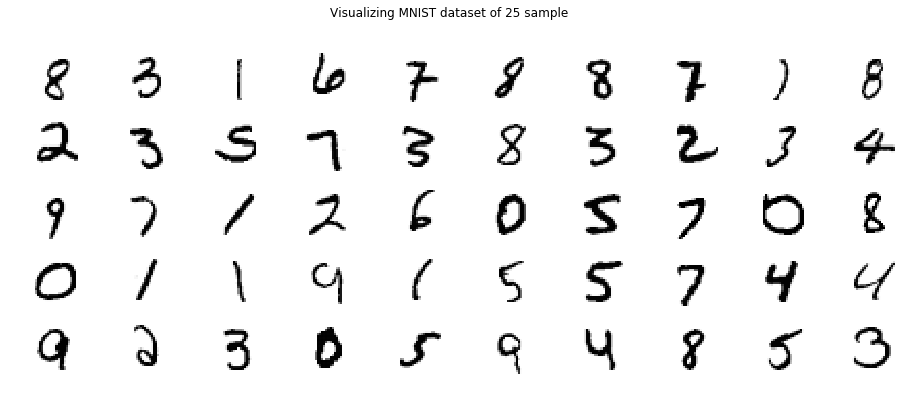

In [86]:
#Visulizing dataset
plt.figure(figsize=(16,6))
plt.suptitle("Visualizing MNIST dataset of 25 sample")
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(mnist.train.images[i].reshape(-1, int(np.sqrt(mnist.train.images[0].shape[0]))), cmap='Greys')
    plt.axis('off')
plt.show()

In [72]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [90]:
graph = tf.Graph()


with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])

    # First convolution layer
    W_conv1 = weight_variable([5, 5, 1, 6]) #32
    b_conv1 = bias_variable([6]) #32

    x_image = tf.reshape(x, [-1, 28, 28, 1])

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

    #Second convolution layer
    W_conv2 = weight_variable([5, 5, 6, 16]) #32, 64
    b_conv2 = bias_variable([16]) #64

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

    #Densly connected layer1
    W_fc1 = weight_variable([7 * 7 * 16, 120]) #64
    b_fc1 = bias_variable([120])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16]) #64
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    #Dropout Layer
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    #Densly connected layer2
    W_fc_temp = weight_variable([120, 84]) #64
    b_fc_temp = bias_variable([84])

    h_pool_temp_flat = tf.reshape(h_fc1_drop, [-1, 120]) #64
    h_fc_temp = tf.nn.relu(tf.matmul(h_pool_temp_flat, W_fc_temp) + b_fc_temp)
    #Dropout Layer
    h_fc_temp_drop = tf.nn.dropout(h_fc_temp, keep_prob)
    
    #Final (prediction) Layer
    W_fc2 = weight_variable([84, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc_temp_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Save variables of model in graph
    saver = tf.train.Saver()

In [91]:
#init_op = tf.global_variables_initializer()

with tf.Session(graph=graph) as sess:
    #sess.run(init_op) 
    tf.global_variables_initializer().run()
    for i in range(20000):
        batch = mnist.train.next_batch(50)
        if i % 1000 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
            val_accuracy = accuracy.eval(feed_dict={x: mnist.validation.images, y_: mnist.validation.labels, keep_prob: 1.0})
            print('step {0:5d}, training accuracy {1:1.2f}, validation accuracy {2:1.4f}'.format(i, train_accuracy, val_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1})

    #Final Model evaluation
    print('test accuracy {0:1.4f}'.format(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})))
    save_path = saver.save(sess, "model_weights_asg/model_nodrop.ckpt")
    print("Model saved in path: {}".format(save_path))

step     0, training accuracy 0.10, validation accuracy 0.1146
step  1000, training accuracy 0.88, validation accuracy 0.9164
step  2000, training accuracy 0.96, validation accuracy 0.9466
step  3000, training accuracy 0.94, validation accuracy 0.9538
step  4000, training accuracy 0.96, validation accuracy 0.9640
step  5000, training accuracy 1.00, validation accuracy 0.9714
step  6000, training accuracy 0.94, validation accuracy 0.9726
step  7000, training accuracy 1.00, validation accuracy 0.9786
step  8000, training accuracy 0.98, validation accuracy 0.9778
step  9000, training accuracy 0.98, validation accuracy 0.9792
step 10000, training accuracy 0.96, validation accuracy 0.9808
step 11000, training accuracy 0.98, validation accuracy 0.9838
step 12000, training accuracy 0.98, validation accuracy 0.9830
step 13000, training accuracy 0.96, validation accuracy 0.9850
step 14000, training accuracy 1.00, validation accuracy 0.9842
step 15000, training accuracy 1.00, validation accuracy

INFO:tensorflow:Restoring parameters from model_weights_asg/model_nodrop.ckpt


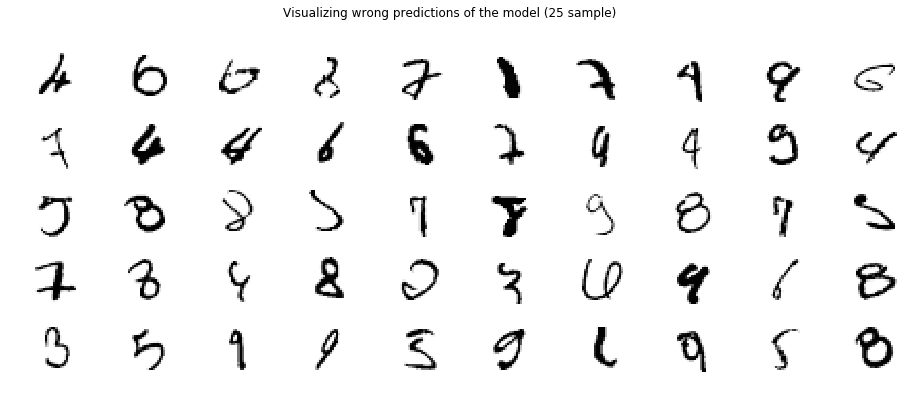

In [92]:
# Check for outliers
with tf.Session(graph=graph) as sess:
    saver.restore(sess, "model_weights_asg/model_nodrop.ckpt")
    wrong_preds = correct_prediction.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
    
#Visulizing outliers in the model
wrong_preds = mnist.test.images[wrong_preds==False]
plt.figure(figsize=(16,6))
plt.suptitle("Visualizing wrong predictions of the model (25 sample)")
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(wrong_preds[i].reshape(-1, int(np.sqrt(mnist.train.images[0].shape[0]))), cmap='Greys')
    plt.axis('off')
plt.show()

### Conclusion:
---
#### Architecture of the model
| Layer            | size         | Parameters        | Value |
|---               |---           |---                | ---   |
|Input             |  28x28x1     | 0                 | 0     |
|Convolution(2D)   |  24x24x6     | 5x5x6x1 + 6       | 156   |
|Maxpool(2stride)  |  12x12x6     | 0                 | 0     |
|Convolution(2D)   |   8x8x16     | 5x5x16x6 + 16     | 2416  |
|Maxpool(2stride)  |   4x4x16     | 0                 | 0     |
|Fully Connected 1 |  120         | 4x4x16x120 + 120  | 30840 |
|Fully Connected 2 |  84          | 120x84 + 84       | 10164 |
|Softmax Final (FC)|  10          | 84x10 + 10        | 850   |
|Total             |              |                   |44,426 |

Test accuracy of 98.6% is observed. By close observation of wrong predicted data we can conclude by visual inspection that the classification of some of them is very hard for humans too. With layers like dropouts and increasing the size of fully connected layer 1 to 1024 neurons the training accuracy has reached to 99.2%. This leads to 8 times more increase in parameters than the current structure.